<a href="https://colab.research.google.com/github/HiepPham1412/model_training/blob/master/Model_Training_LC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r model_training
!git clone https://github.com/HiepPham1412/model_training.git

In [ ]:
#!pip install ppscore
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pandas.core.common import flatten
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import GridSearchCV


from model_training.config import selected_vars
from model_training.config import loan_col , heavy_missing_val_cols, questionable_vars, final_cols
from model_training.config import nans, outliers_bound, less_pred_cols, log_scaled_cols
from model_training.feature_engineering import NATransformer, OutlierTransformer, CatVarTransformer, ContVarTransformer, MyStandardScaler

# Data preparation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# load and split data
data_path = 'drive/My Drive/data/df_loans_matured.pkl'
df_loans = pd.read_pickle(data_path)
df_loans = df_loans[final_cols + ['tot_cur_bal']]
df_loans = df_loans.set_index('id', drop=True)
df_train, df_test = train_test_split(df_loans, 
                           test_size=0.3, 
                           random_state=123,
                           stratify=df_loans['is_defaulted'])

In [ ]:
# config feature engineering pipeline
steps = [('NA', NATransformer()), ('Outlier', OutlierTransformer()), 
        ('Cont', ContVarTransformer(log_transform=False, polynomial_term=True)), 
        ('Cat', CatVarTransformer()), ('Scale', MyStandardScaler())]
pipeline = Pipeline(steps, verbose=False)

# transform the data
df_train_transformed = pipeline.fit_transform(df_train)
df_test_transformed = pipeline.transform(df_test)

X_train = df_train_transformed[selected_vars]
y_train = df_train_transformed['is_defaulted']

X_test = df_test_transformed[selected_vars]
y_test = df_test_transformed['is_defaulted']

In [ ]:
def grid_search(estimator, params, X_train, y_train, X_test, y_test, **kwargs):
  gs_cv= GridSearchCV(estimator, 
                    param_grid=params, 
                    scoring='roc_auc', 
                    n_jobs=3, 
                    refit=True, 
                    cv=3, 
                    **kwargs)
  gs_cv.fit(X_train, y_train)
  y_hat_test = gs_cv.predict_proba(X_test)[:, 1]
  test_score = roc_auc_score(np.ravel(y_test), y_hat_test)
  cv_result = pd.DataFrame(gs_cv.cv_results_)
  cv_result['model'] = str(estimator.__class__.__name__)
  cv_result['out_of_sample_score'] = test_score
  selected_cols = ['model', 'out_of_sample_score', 'mean_test_score', 
                   'std_test_score', 'rank_test_score', 'params', 'mean_score_time']
  cv_result = cv_result[selected_cols]
  
  return cv_result, gs_cv

# 1. Logistic regression (base model)

In [ ]:
lr_estimator = LogisticRegression()
parameters = {'random_state': [123], 
              'penalty': ['l1', 'l2'],
              'solver': ['newton-cg', 'saga', 'lbfgs']}
lg_cv_result, lg_gs_cv = grid_search(estimator=lr_estimator, 
                           params=parameters, 
                           X_train=X_train, 
                           y_train=y_train,
                           X_test=X_test, 
                           y_test=y_test)
lg_cv_result

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,model,out_of_sample_score,mean_test_score,std_test_score,rank_test_score,params,mean_score_time
0,LogisticRegression,0.679226,NaN,NaN,5,"{'penalty': 'l1', 'random_state': 123, 'solver...",0.000000
1,LogisticRegression,0.679226,0.682895,0.000307,4,"{'penalty': 'l1', 'random_state': 123, 'solver...",0.186638
2,LogisticRegression,0.679226,NaN,NaN,6,"{'penalty': 'l1', 'random_state': 123, 'solver...",0.000000
3,LogisticRegression,0.679226,0.683022,0.000268,1,"{'penalty': 'l2', 'random_state': 123, 'solver...",0.155630
4,LogisticRegression,0.679226,0.682900,0.000308,3,"{'penalty': 'l2', 'random_state': 123, 'solver...",0.176139
5,LogisticRegression,0.679226,0.682997,0.000289,2,"{'penalty': 'l2', 'random_state': 123, 'solver...",0.117310


In [ ]:
lg_cv_result.to_csv('drive/My Drive/data/lg_cv_result.csv')
joblib.dump(lg_gs_cv, 'drive/My Drive/data/lg_gs_cv.pkl')

## 2. RandomForest



In [ ]:
rf_estimator = RandomForestClassifier( )
rf_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [20, 50],
              'min_samples_leaf': [20, 50],
              'n_estimators': [100, 150],
              'n_jobs': [3],
              'random_state': [123],
              'verbose': [2]}
rf_cv_result, rf_gs_cv = grid_search(estimator=rf_estimator, 
                           params=rf_params, 
                           X_train=X_train, 
                           y_train=y_train,
                           X_test=X_test, 
                           y_test=y_test)
rf_cv_result

In [ ]:
rf_cv_result.to_csv('drive/My Drive/data/rf_cv_result.csv')
joblib.dump(rf_gs_cv, 'drive/My Drive/data/rf_cv_result.pkl')

['drive/My Drive/data/rf_cv_result.pkl']

In [ ]:
rf_cv_result.to_csv('drive/My Drive/data/rf_cv_result.csv')

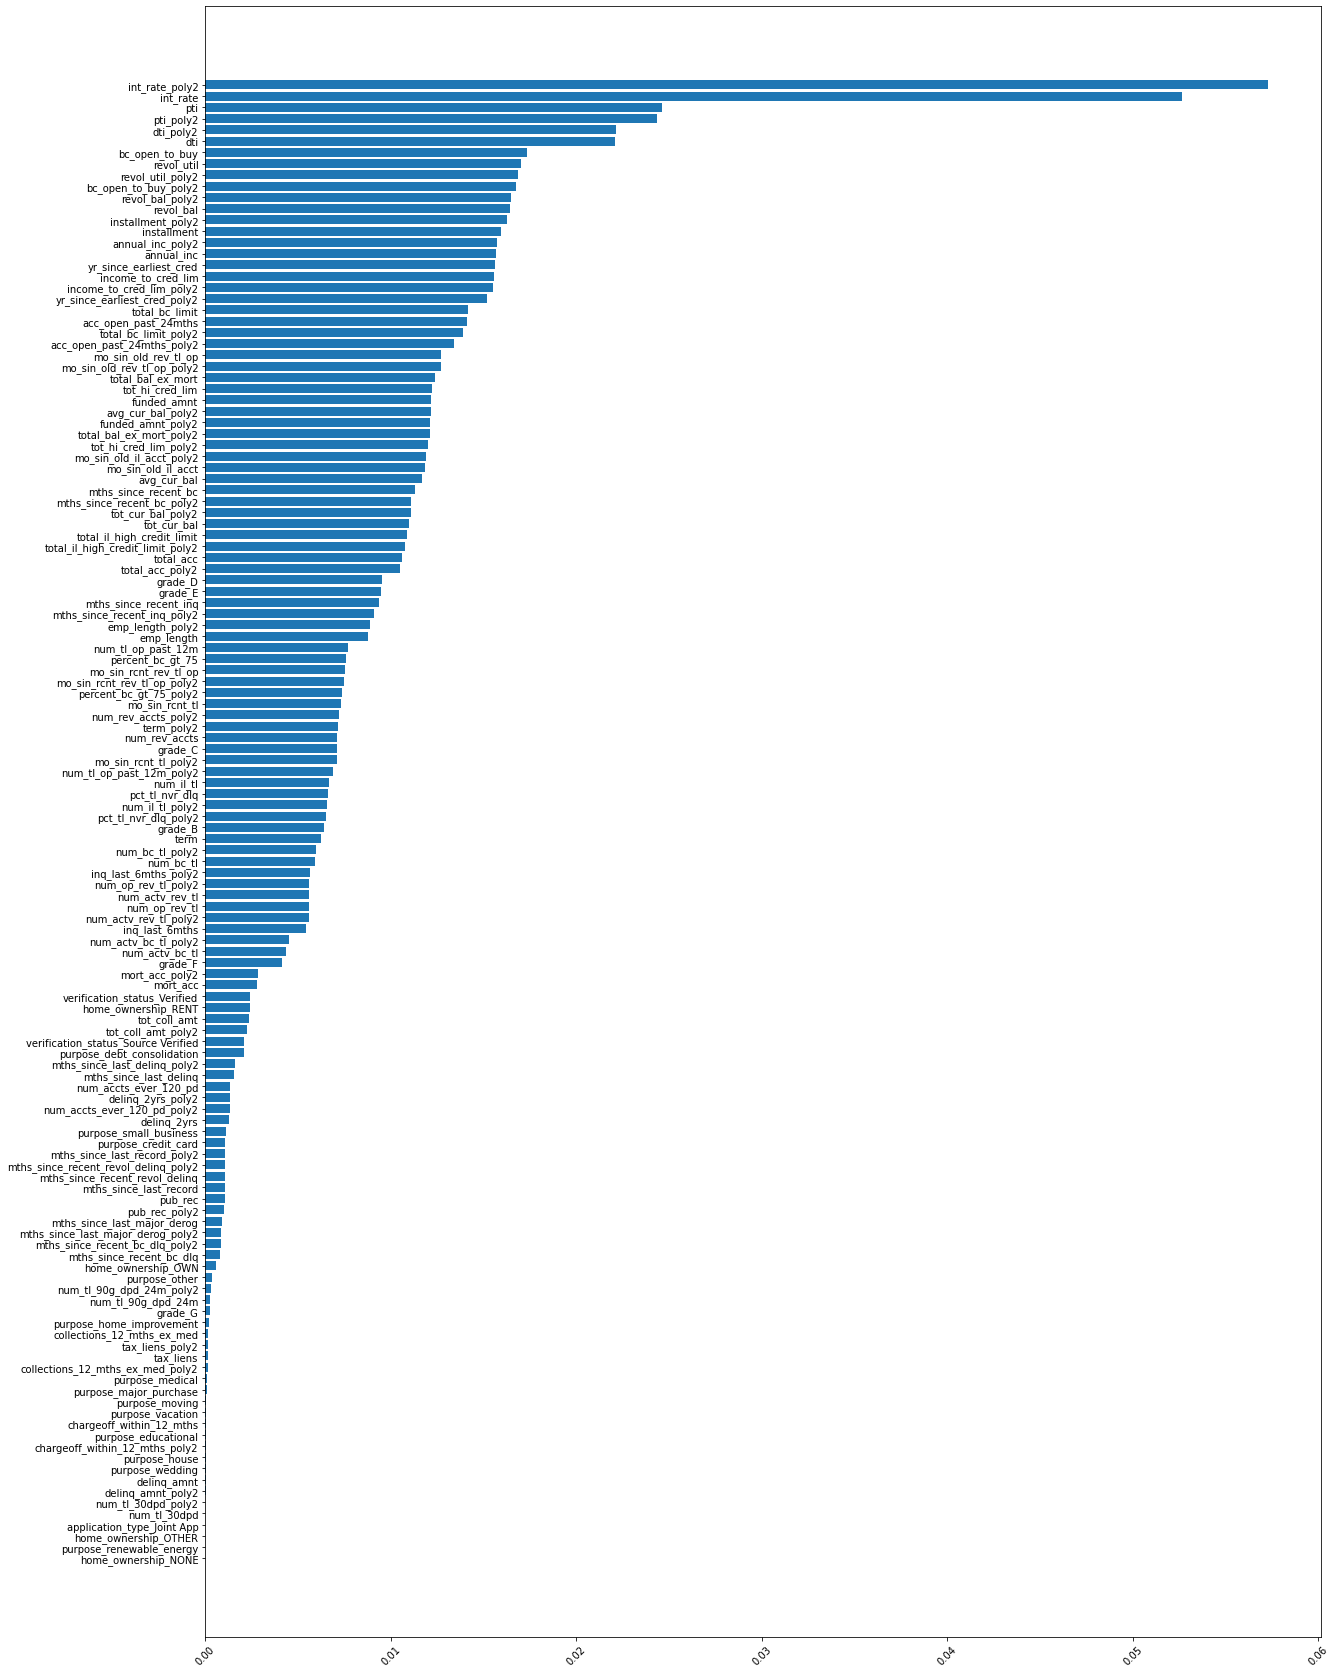

In [ ]:
#classification_report(y_train, y_hat_train, output_dict=True)
y_hat_train = best_estimator.predict_proba(X_train)[:, 1]
y_hat_test = best_estimator.predict_proba(X_test)[:, 1]
roc_auc_score_train = roc_auc_score(y_train, y_hat_train)
roc_auc_score_test =  roc_auc_score(y_test, y_hat_test)
print(f'ROC-AUC score train: {roc_auc_score_train}, test: {roc_auc_score_test}')

fig, ax = plt.subplots(1, 1, figsize=(20, 30))
sorted_index = np.argsort(best_estimator.feature_importances_)
ax.barh(X_train.columns[sorted_index], 
       best_estimator.feature_importances_[sorted_index])
ax.xaxis.set_tick_params(rotation=45)

In [ ]:
rf_cv_result = pd.read_csv('drive/My Drive/data/rf_cv_result.csv')
best_params = rf_cv_result.query('rank_test_score == 1').params.values[0]

"{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 50, 'n_estimators': 150, 'n_jobs': 3, 'random_state': 123}"

# 3. Boosting

In [ ]:
init_estimator = LogisticRegression()
gb_estimator = GradientBoostingClassifier()
gb_parameters = {'n_estimators': [100],
                'learning_rate': [0.01],
                'max_depth': [30],
                'min_samples_leaf': [50],
                'random_state': [123],
                'verbose': [2]}
gb_cv_result, gb_gs_cv = grid_search(estimator=gb_estimator,
                           params=gb_parameters,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test)
gb_cv_result

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


      Iter       Train Loss   Remaining Time 
         1           0.8290           77.82m
         2           0.8271           75.75m
         3           0.8252           75.42m
         4           0.8234           75.29m
         5           0.8217           74.56m
         6           0.8199           74.18m
         7           0.8182           73.80m
         8           0.8164           73.30m
         9           0.8147           72.72m
        10           0.8130           71.60m
        11           0.8112           70.45m
        12           0.8095           69.41m
        13           0.8078           68.29m
        14           0.8060           67.34m
        15           0.8043           66.52m
        16           0.8027           65.75m
        17           0.8010           65.24m
        18           0.7993           64.50m
        19           0.7977           63.82m
        20           0.7961           63.14m
        21           0.7945           62.51m
        2

In [ ]:
gb_cv_result.to_csv('drive/My Drive/data/gb_cv_result.csv')
joblib.dump(gb_gs_cv, 'drive/My Drive/data/gb_gs_cv.pkl')

## 3.1 Xgboost

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
xg_estimator = XGBClassifier()
xg_parameters = {'objective':['binary:logistic'],
                 'max_depth': [4, 8],
                 'verbosity': [2]}
xg_cv_result, xg_gs_cv = grid_search(estimator=xg_estimator,
                           params=xg_parameters,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test)
xg_cv_result

[20:07:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=8
[20:07:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[20:07:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[20:07:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[20:07:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[20:07:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[20:07:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=8
[20:07:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 e

,model,out_of_sample_score,mean_test_score,std_test_score,rank_test_score,params,mean_score_time
0,XGBClassifier,0.685073,0.685481,0.000621,2,"{'max_depth': 4, 'objective': 'binary:logistic...",1.389676
1,XGBClassifier,0.685073,0.685974,0.000599,1,"{'max_depth': 8, 'objective': 'binary:logistic...",1.795612


In [ ]:
xg_cv_result.to_csv('drive/My Drive/data/xg_cv_result.csv')
joblib.dump(xg_gs_cv, 'drive/My Drive/data/xg_gs_cv.pkl')

['drive/My Drive/data/xg_gs_cv.pkl']

# 4. SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_estimator = SVC()
svm_parameters = {'C':[1],
                 'kernel': ['rbf'],
                 'verbose': [2]}
svm_cv_result, svm_gs_cv = grid_search(estimator=svm_estimator,
                                      params=svm_parameters,
                                      X_train=X_train,
                                      y_train=y_train,
                                      X_test=X_test,
                                      y_test=y_test)
svm_cv_result

In [ ]:
svm_cv_result.to_csv('drive/My Drive/data/svm_cv_result.csv')
joblib.dump(svm_gs_cv, 'drive/My Drive/data/svm_gs_cv.pkl')

#5. Neural Network

# 6. Model stacking

## 6.1 Best 3

## 6.1 Avg all